In [45]:
# install.packages("MASS",repos="http://cran.rstudio.com/" )
library("MASS")
set.seed(10)

n_vars <- 4 #number of x variables
corr <- 0.99 #correlation between x to build multicolinearity
nobs <- 1000 #number of rows in dataset
error_sd <- 10
intercept <- 5

#Build variance covariance matrix between variables, here
#it's 1s on the diagonal
m <- matrix(rep(0.5,n_vars^2), n_vars)
diag(m) <- 1

#Build dataset - num vars, mean, and covariance matrix.
X <- mvrnorm(n = nobs, rep(0, n_vars), m,  tol = 1e-6)
e <- rnorm(nobs,intercept,error_sd)

#Model
b <- c(10,12,0,0)
y <- X %*% b + e

df <- data.frame(e, y, X)

#Split into a test and a training set
library(caret)
trainIndex <- createDataPartition(df$y, p = .75,
                                  list = FALSE,
                                  times = 1)

df_train <- df[ trainIndex,]
df_test  <- df[-trainIndex,]

train_for_model <- df_train[,-1] #to prevent putting the e as explanatory variable

In [46]:
#Fit the real model
lm_real <- lm(y~X1 + X2, data=train_for_model)
summary(lm_real) #Note coefficients are quite close to reality


Call:
lm(formula = y ~ X1 + X2, data = train_for_model)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.261  -6.532  -0.261   6.800  29.584 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.0777     0.3640   13.95   <2e-16 ***
X1           10.0109     0.4129   24.25   <2e-16 ***
X2           11.8685     0.4015   29.56   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.982 on 749 degrees of freedom
Multiple R-squared:  0.7828,	Adjusted R-squared:  0.7823 
F-statistic:  1350 on 2 and 749 DF,  p-value: < 2.2e-16


In [47]:
#Fit a linear model with all cross terms 
quadratic_terms <- paste("I(",names(train_for_model)[-1], "^2)",collapse="+")
reg_formula <- paste("y~.^3 + ", quadratic_terms)
lm_overfit <- lm(reg_formula, data=train_for_model)
coef_overfit <- coef(lm_fit)
summary(lm_overfit) #Note the coefficients are much less accurate


Call:
lm(formula = reg_formula, data = train_for_model)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.134  -6.444   0.051   6.605  28.178 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.42595    0.64153   8.458   <2e-16 ***
X1           9.63332    0.49991  19.270   <2e-16 ***
X2          11.69087    0.50161  23.307   <2e-16 ***
X3          -0.48884    0.49877  -0.980   0.3274    
X4           0.65736    0.52140   1.261   0.2078    
I(X1^2)     -0.24169    0.38750  -0.624   0.5330    
I(X2^2)      0.13261    0.39740   0.334   0.7387    
I(X3^2)      0.16101    0.35015   0.460   0.6458    
I(X4^2)     -0.67896    0.41513  -1.636   0.1024    
X1:X2       -0.82272    0.57200  -1.438   0.1508    
X1:X3       -0.02816    0.55178  -0.051   0.9593    
X1:X4        1.55221    0.59269   2.619   0.0090 ** 
X2:X3        0.57669    0.58325   0.989   0.3231    
X2:X4        0.39309    0.55202   0.712   0.4766    
X3:X4       -1.11774    0.60061  -1.861

In [75]:
#Now let's estimate the same model with LASSO
library(glmnet)
in_matrix_form_for_glmnet <- model.matrix(y ~ .^3 + I(X1^2) + I(X2^2) + I(X3^2) + I(X4^2), data=train_for_model)
fit_lasso<-glmnet(in_matrix_form_for_glmnet,train_for_model$y,lambda=seq(1,0.01,-0.01))

In [79]:
#Cross validate the model
fit_lasso_cv <- cv.glmnet(in_matrix_form_for_glmnet,train_for_model$y,lambda=seq(1,0.01,-0.01))

ERROR: Error in replayPlot(obj): invalid graphics state


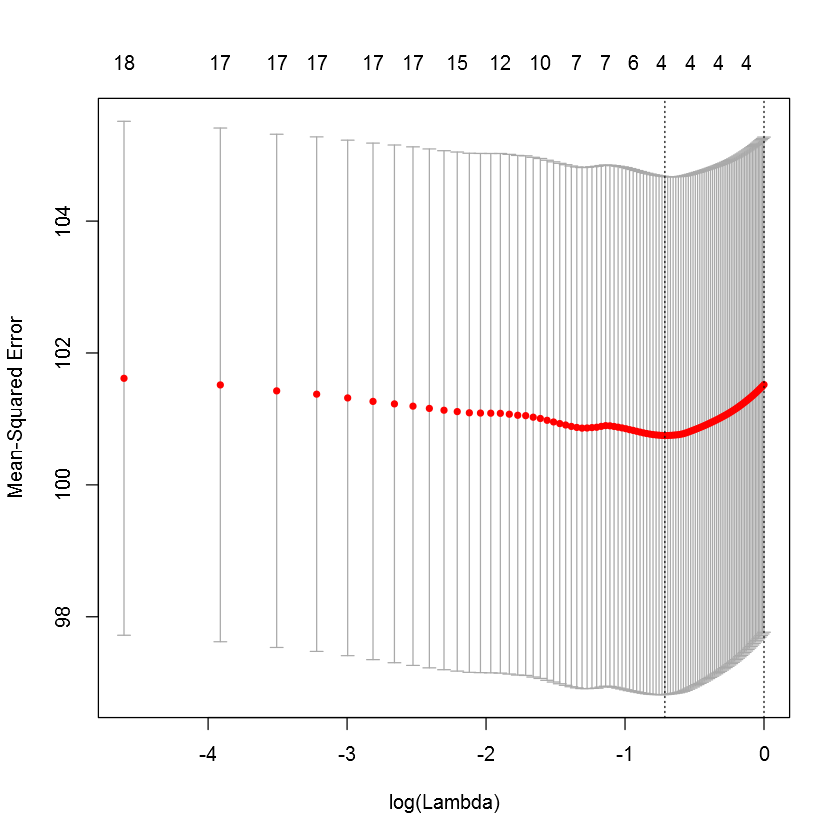

In [80]:
plot(fit_lasso_cv) 

In [118]:
best <- glmnet(in_matrix_form_for_glmnet,train_for_model$y,lambda=fit_lasso_cv$lambda.min)
print(best$a0)
print(best$beta)

      s0 
5.076172 
19 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept)  .        
X1           9.5002706
X2          11.3597248
X3           .        
X4           0.2531598
I(X1^2)      .        
I(X2^2)      .        
I(X3^2)      .        
I(X4^2)      .        
X1:X2        .        
X1:X3        .        
X1:X4        .        
X2:X3        .        
X2:X4        .        
X3:X4        .        
X1:X2:X3     .        
X1:X2:X4     0.1725520
X1:X3:X4     .        
X2:X3:X4     .        


s0 
5.076172